
# AeDataset — **sa_copy_paste** Inter‑Sketch Augmentation Tester

This notebook instantiates `AeDataset` with **`sa_copy_paste=True`** to verify the inter‑sketch copy‑paste pipeline and preview its effect.

**What you get**
- Paths & image size are auto‑filled from `train_Embed.py` (can be edited).  
- Two datasets are created:
  - `ds_base`: no copy‑paste (baseline preview)
  - `ds_cp`  : copy‑paste ON (probability forced to 1.0 just for preview)
- Visual preview for a few indices: **Target (raw/dist)** → **Template used** → **After copy‑paste (raw/dist)**.

If your data structure matches the screenshot (`data_embed_pt/{train,test}/*.pt`), you are good to go.


In [1]:

import os, sys, random
from pathlib import Path
import numpy as np
import torch
import matplotlib.pyplot as plt

# Local modules
from loader import AeDataset
random.seed(0); np.random.seed(0); torch.manual_seed(0)


C:\Users\User\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\albumentations\__init__.py:28: UserWarning: A new version of AlbumentationsX (2.0.10) is available! Your version is 2.0.9. Upgrade using: pip install -U albumentationsx
  check_for_updates()


In [2]:

# === Config (auto from train_Embed.py with editable fallbacks) ===
DB_DIR_DEFAULT = "data_embed_pt"
IMG_SIZE_DEFAULT = 256
PREFIX_DEFAULT = "train"  # 'train' or 'test'

try:
    import importlib.util, types
    spec = importlib.util.spec_from_file_location('train_Embed', 'train_Embed.py')
    mod = importlib.util.module_from_spec(spec)
    spec.loader.exec_module(mod)
    hp = getattr(mod, 'hyper_params', {})
    DB_DIR_DEFAULT = hp.get('dbDir', DB_DIR_DEFAULT)
    IMG_SIZE_DEFAULT = hp.get('imgSize', IMG_SIZE_DEFAULT)
except Exception as e:
    print("[Info] Could not import train_Embed.py defaults:", e)

DB_DIR  = DB_DIR_DEFAULT
IMG_SIZE = IMG_SIZE_DEFAULT
PREFIX = PREFIX_DEFAULT

print("DB_DIR =", DB_DIR)
print("IMG_SIZE =", IMG_SIZE, " | PREFIX =", PREFIX)
print("Expecting .pt files under:", os.path.join(DB_DIR, PREFIX))


DB_DIR = data_embed_pt
IMG_SIZE = 256  | PREFIX = train
Expecting .pt files under: data_embed_pt\train


In [3]:

# === Build datasets ===
# Baseline: no inter-sketch copy-paste
ds_base = AeDataset(DB_DIR, [IMG_SIZE, IMG_SIZE], PREFIX, augment=False,
                    sa_copy_paste=False)

# Copy-paste ON (force probability to 1.0 for deterministic preview)
ds_cp = AeDataset(DB_DIR, [IMG_SIZE, IMG_SIZE], PREFIX, augment=False,
                  sa_copy_paste=True, sa_cp_prob=1.0,
                  sa_cp_min_comp_px=20, sa_cp_max_overlap=0.35, sa_cp_max_trials=10,
                  sa_cp_same_class_only=False)

print("Num files:", len(ds_base))
assert len(ds_base) > 0, "No .pt files found. Please check DB_DIR/PREFIX."


Num files: 25084


In [4]:

def show_im(ax, img, title):
    ax.imshow(img, cmap='gray', vmin=0, vmax=1)
    ax.set_title(title); ax.axis('off')

def to01(t):
    t = t.detach().cpu()
    if t.dim()==3 and t.size(0)==1: t = t.squeeze(0)
    t = t.to(torch.float32)
    if t.max()>1: t = t/255.0
    return t.clamp(0,1).numpy()

def preview_index(idx):
    # 1) original (no copy-paste)
    raw0, dis0 = ds_base[idx]
    raw0_np, dis0_np = to01(raw0), to01(dis0)

    # 2) ask ds_cp what template it would pick, and fetch raw template
    #    (so the preview shows what got pasted)
    tidx = ds_cp._pick_template_index(idx)
    t_raw = ds_cp._fetch_template_raw(tidx)
    t_raw_np = to01(t_raw)

    # 3) after copy-paste (probability=1.0 ensures it will apply)
    raw1, dis1 = ds_cp[idx]
    raw1_np, dis1_np = to01(raw1), to01(dis1)

    fig, axes = plt.subplots(1, 5, figsize=(5*3.4, 3.4))
    show_im(axes[0], raw0_np, f"Target RAW (idx={idx})")
    show_im(axes[1], dis0_np, "Target DIST")
    show_im(axes[2], t_raw_np, f"Template RAW (idx={tidx})")
    show_im(axes[3], raw1_np, "After CP — RAW")
    show_im(axes[4], dis1_np, "After CP — DIST")
    plt.tight_layout(); plt.show()


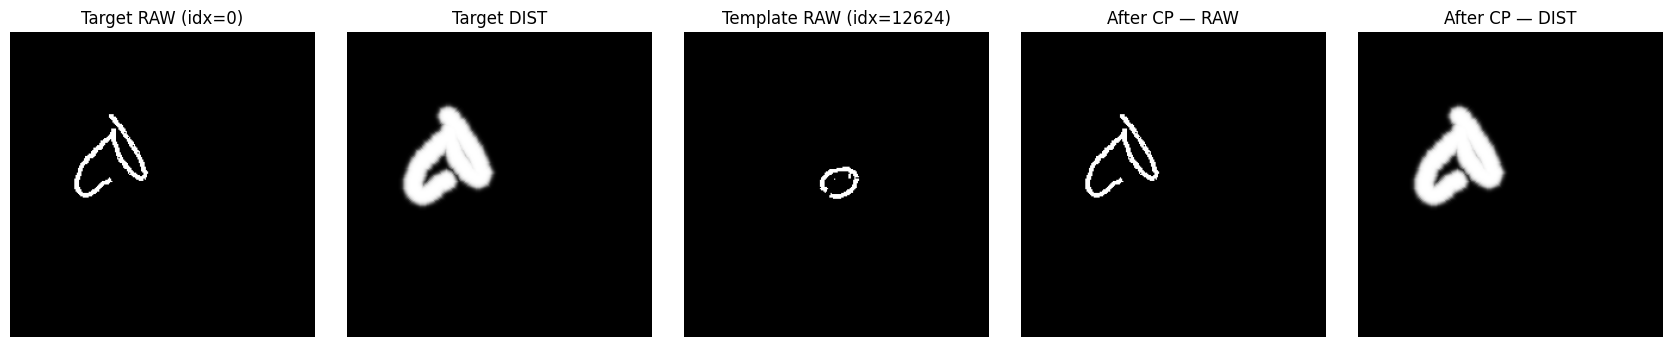

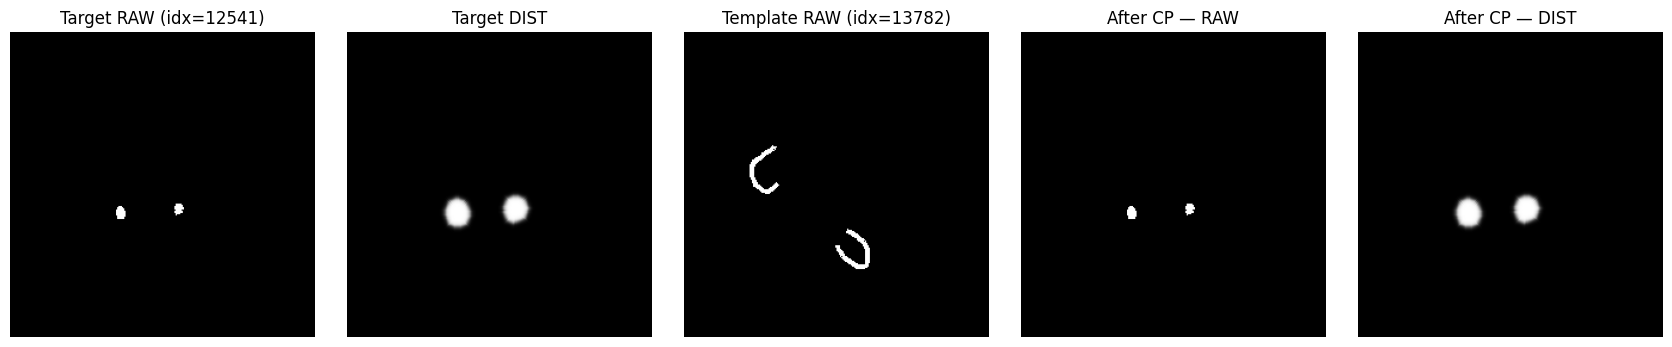

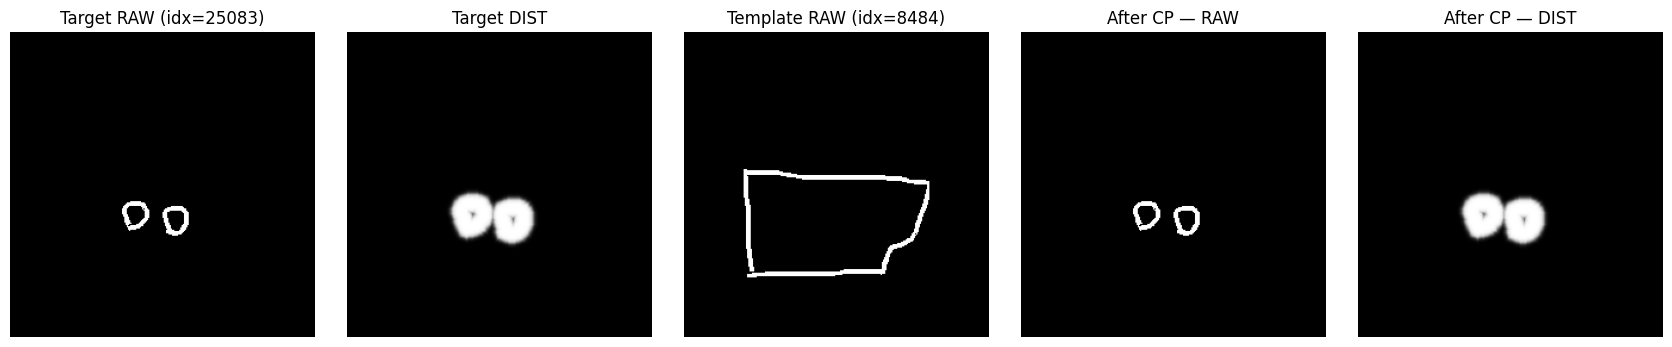

In [5]:

# === Run a quick preview on a few evenly spaced indices ===
n_show = min(3, len(ds_base))
indices = np.linspace(0, len(ds_base)-1, num=n_show, dtype=int)
for i in indices:
    preview_index(int(i))



### Notes
- `sa_cp_prob` is set to `1.0` here so that **copy‑paste is guaranteed** for preview. In training, you can set it lower (e.g., 0.3~0.7).  
- `sa_cp_same_class_only=True` will restrict template selection to the same class—this depends on how your directory names encode class IDs.
- Dataset logic, copy‑paste, and distance recomputation are implemented in your repository (`AeDataset` and `sa_copy_paste.py`).


## 🔧 New: Test **Semantic Constraints** for `sa_copy_paste`

This section lets you preview **where** the component is pasted:

- `constraint="none"`: random placement (previous behavior).  
- `constraint="inside_largest"`: paste **inside the target's largest connected foreground region** (a simple semantic proxy for head/body).  
- `constraint="provided_mask"`: (optional) paste inside a custom mask you provide.

The code first **tries to use loader-level arguments** (`sa_cp_constraint`, `sa_cp_keep_inside`, `sa_cp_constraint_mask`). If your current `AeDataset` does not yet expose those, it **falls back to direct mode** by calling `sa_copy_paste_apply(...)` just for preview.


In [6]:

from sa_copy_paste import sa_copy_paste_apply
import numpy as np


In [7]:

# === Constraint Config ===
CP_CONSTRAINT = "inside_largest"   # "none" | "inside_largest" | "provided_mask"
CP_KEEP_INSIDE = True              # If True, paste entirely inside the area
CP_PROB = 1.0                      # Force apply for preview
CP_MIN_COMP = 20
CP_MAX_OVERLAP = 0.35
CP_MAX_TRIALS = 20

# Optional custom mask for "provided_mask" (example: center square); set to None to skip
CUSTOM_MASK = None
# Example to try later:
# H = W = IMG_SIZE
# CUSTOM_MASK = np.zeros((H, W), dtype=np.uint8)
# CUSTOM_MASK[H//4:3*H//4, W//4:3*W//4] = 1


In [8]:

# Try to construct a dataset that forwards constraint args (if loader supports them)
supports_loader_constraint = False
try:
    ds_cp_constraint = AeDataset(DB_DIR, [IMG_SIZE, IMG_SIZE], PREFIX, augment=False,
                                 sa_copy_paste=True, sa_cp_prob=CP_PROB,
                                 sa_cp_min_comp_px=CP_MIN_COMP, sa_cp_max_overlap=CP_MAX_OVERLAP,
                                 sa_cp_max_trials=CP_MAX_TRIALS, sa_cp_same_class_only=False,
                                 # hopeful args:
                                 sa_cp_constraint=CP_CONSTRAINT,
                                 sa_cp_keep_inside=CP_KEEP_INSIDE,
                                 sa_cp_constraint_mask=CUSTOM_MASK)
    # Try to fetch one item to ensure it actually runs
    _ = ds_cp_constraint[0]
    supports_loader_constraint = True
    print("[OK] Loader accepted constraint args; using loader-level test.")
except Exception as e:
    print("[Info] Loader likely doesn't expose constraint args yet. Falling back to direct mode:", e)
    ds_cp_constraint = None


[Info] Loader likely doesn't expose constraint args yet. Falling back to direct mode: AeDataset.__init__() got an unexpected keyword argument 'sa_cp_constraint'


In [9]:

def preview_constraint(idx):
    raw0, dis0 = ds_base[idx]
    def to01(t):
        t = t.detach().cpu().to(torch.float32)
        if t.dim()==3 and t.size(0)==1: t = t.squeeze(0)
        if t.max()>1: t = t/255.0
        return t.clamp(0,1)

    raw0_01, dis0_01 = to01(raw0), to01(dis0)

    # For display
    def im(ax, x, title): ax.imshow(x, cmap='gray', vmin=0, vmax=1); ax.set_title(title); ax.axis('off')

    if supports_loader_constraint:
        # Use loader-side dataset that already applies the constraint
        raw1, dis1 = ds_cp_constraint[idx]
        raw1_np, dis1_np = raw1.squeeze(0).cpu().numpy(), dis1.squeeze(0).cpu().numpy()

        fig, axes = plt.subplots(1, 3, figsize=(3*3.6, 3.2))
        im(axes[0], raw0_01.numpy(), f"Target RAW (idx={idx})")
        im(axes[1], raw1_np, f'RAW after CP (constraint="{CP_CONSTRAINT}")')
        im(axes[2], dis1_np, "DIST after CP")
        plt.tight_layout(); plt.show()
        return

    # --- Direct mode: call sa_copy_paste_apply here just for the preview ---
    # Reuse template selection and fetching from ds_cp
    tidx = ds_cp._pick_template_index(idx)
    t_raw = ds_cp._fetch_template_raw(tidx)

    # none (baseline) vs constrained
    raw_none, dis_none = sa_copy_paste_apply(
        idx=idx, raw01=raw0_01.unsqueeze(0) if raw0_01.dim()==2 else raw0_01,
        dis01=dis0_01.unsqueeze(0) if dis0_01.dim()==2 else dis0_01,
        fetch_template_raw=lambda k: t_raw,
        pick_template_index=lambda _: tidx,
        prob=1.0, min_comp_px=CP_MIN_COMP, max_overlap=CP_MAX_OVERLAP, max_trials=CP_MAX_TRIALS,
        constraint="none",
    )

    raw_cons, dis_cons = sa_copy_paste_apply(
        idx=idx, raw01=raw0_01.unsqueeze(0) if raw0_01.dim()==2 else raw0_01,
        dis01=dis0_01.unsqueeze(0) if dis0_01.dim()==2 else dis0_01,
        fetch_template_raw=lambda k: t_raw,
        pick_template_index=lambda _: tidx,
        prob=1.0, min_comp_px=CP_MIN_COMP, max_overlap=CP_MAX_OVERLAP, max_trials=CP_MAX_TRIALS,
        constraint=CP_CONSTRAINT,
        constraint_mask=CUSTOM_MASK, keep_inside=CP_KEEP_INSIDE
    )

    fig, axes = plt.subplots(1, 5, figsize=(5*3.4, 3.2))
    im(axes[0], raw0_01.numpy(), f"Target RAW (idx={idx})")
    im(axes[1], raw_none[0].squeeze(0).cpu().numpy(), 'After CP — RAW (none)')
    im(axes[2], raw_cons[0].squeeze(0).cpu().numpy(), f'After CP — RAW ("{CP_CONSTRAINT}")')
    im(axes[3], dis_cons[0].squeeze(0).cpu().numpy(), "After CP — DIST (constrained)")
    im(axes[4], (CUSTOM_MASK if CUSTOM_MASK is not None else np.zeros_like(raw0_01.numpy())), "Constraint mask")
    plt.tight_layout(); plt.show()


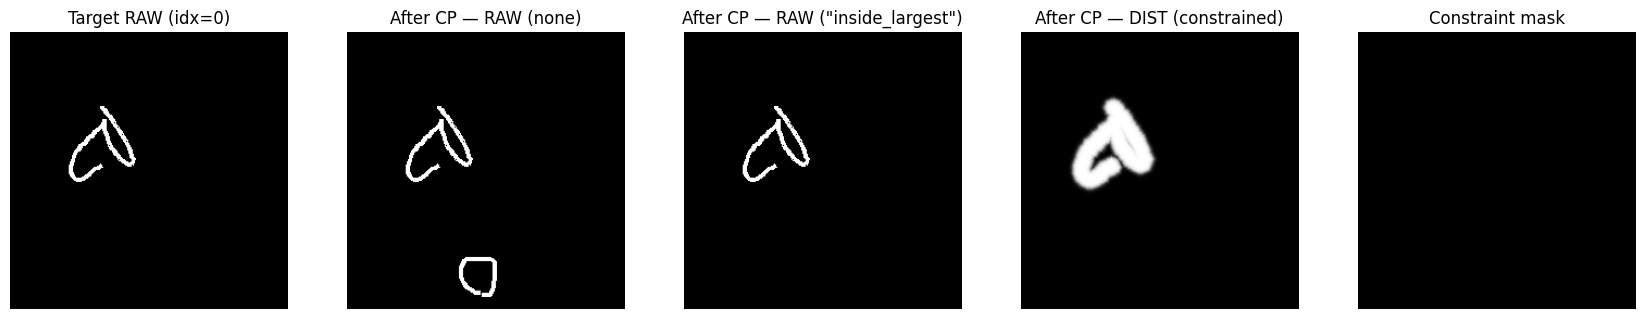

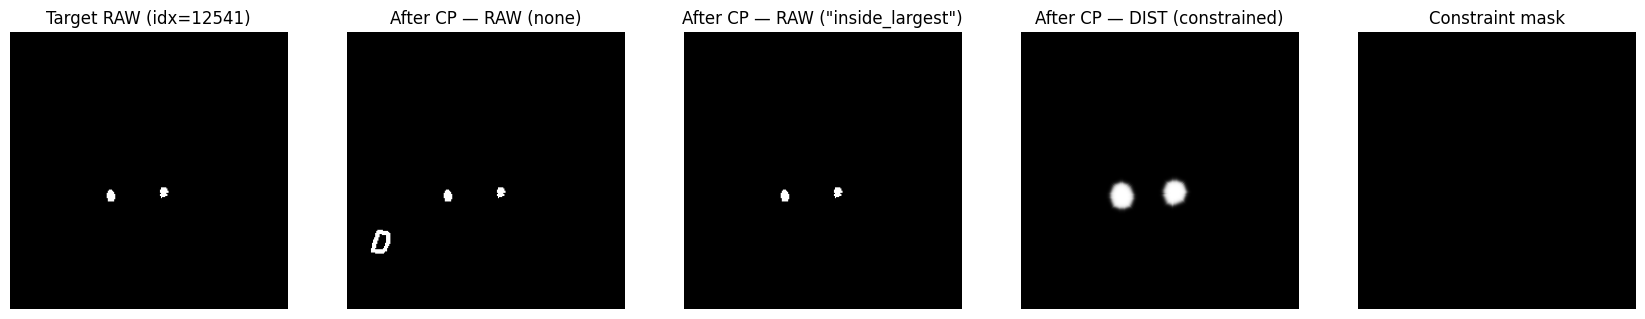

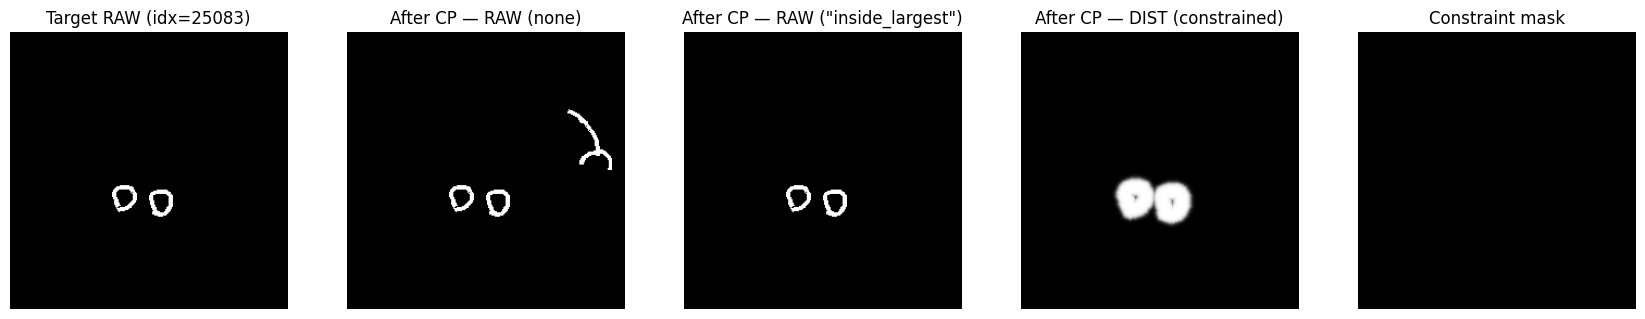

In [10]:

# === Run the constrained preview on a few indices ===
n_show = min(3, len(ds_base))
indices = np.linspace(0, len(ds_base)-1, num=n_show, dtype=int)
for i in indices:
    preview_constraint(int(i))
